In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.units import cds
cds.enable() 
from astropy import time, coordinates as coord

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Looking at the tgcat data for GD394

In [2]:
path = '/media/david/1tb_storage1/emergency_data/gd394/chandra/tgcat/'
obs = glob.glob('{}obs*'.format(path))
obs

['/media/david/1tb_storage1/emergency_data/gd394/chandra/tgcat/obs_21181_tgid_6072',
 '/media/david/1tb_storage1/emergency_data/gd394/chandra/tgcat/obs_22956_tgid_6070']

In [3]:
# os.listdir(obs[0])

In [4]:
lc1 = fits.open('{}/lc'.format(obs[0]))

In [5]:
lc1.info()

Filename: /media/david/1tb_storage1/emergency_data/gd394/chandra/tgcat/obs_21181_tgid_6072/lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    305   52R x 10C   [1J, 1D, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1D]   
  2  GTI           1 BinTableHDU     26   1R x 2C   [1D, 1D]   


In [6]:
data = lc1[1].data

In [7]:
data.names

['TIME_BIN',
 'TIME_MIN',
 'TIME',
 'TIME_MAX',
 'COUNTS',
 'STAT_ERR',
 'AREA',
 'EXPOSURE',
 'COUNT_RATE',
 'COUNT_RATE_ERR']

<ErrorbarContainer object of 3 artists>

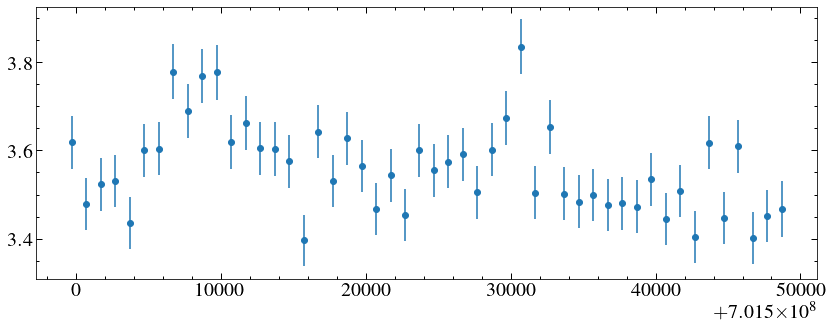

In [8]:
plt.errorbar(data['TIME'][1:-1], data['COUNT_RATE'][1:-1], yerr=data['COUNT_RATE_ERR'][1:-1], marker='o', ls='none')

In [9]:
bg1 = fits.open('{}/lc_bg'.format(obs[0]))

In [10]:
bgdata = bg1[1].data

In [11]:
bgdata.names

['TIME_BIN',
 'TIME_MIN',
 'TIME',
 'TIME_MAX',
 'COUNTS',
 'STAT_ERR',
 'AREA',
 'EXPOSURE',
 'COUNT_RATE',
 'COUNT_RATE_ERR']

<ErrorbarContainer object of 3 artists>

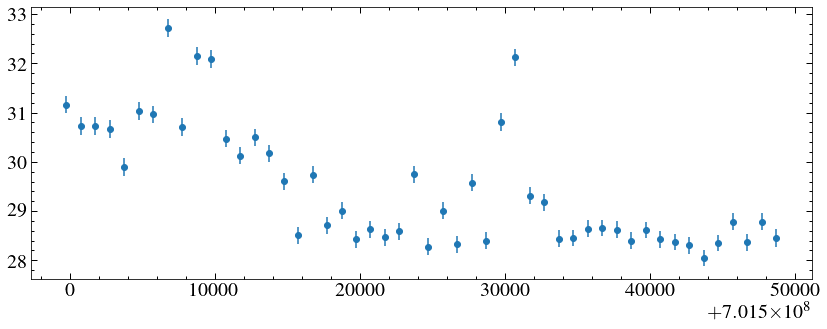

In [12]:
plt.errorbar(bgdata['TIME'][1:-1], bgdata['COUNT_RATE'][1:-1], yerr=bgdata['COUNT_RATE_ERR'][1:-1], marker='o', ls='none')

In [13]:
bgdata['TIME']

array([7.01498713e+08, 7.01499713e+08, 7.01500713e+08, 7.01501713e+08,
       7.01502713e+08, 7.01503713e+08, 7.01504713e+08, 7.01505713e+08,
       7.01506713e+08, 7.01507713e+08, 7.01508713e+08, 7.01509713e+08,
       7.01510713e+08, 7.01511713e+08, 7.01512713e+08, 7.01513713e+08,
       7.01514713e+08, 7.01515713e+08, 7.01516713e+08, 7.01517713e+08,
       7.01518713e+08, 7.01519713e+08, 7.01520713e+08, 7.01521713e+08,
       7.01522713e+08, 7.01523713e+08, 7.01524713e+08, 7.01525713e+08,
       7.01526713e+08, 7.01527713e+08, 7.01528713e+08, 7.01529713e+08,
       7.01530713e+08, 7.01531713e+08, 7.01532713e+08, 7.01533713e+08,
       7.01534713e+08, 7.01535713e+08, 7.01536713e+08, 7.01537713e+08,
       7.01538713e+08, 7.01539713e+08, 7.01540713e+08, 7.01541713e+08,
       7.01542713e+08, 7.01543713e+08, 7.01544713e+08, 7.01545713e+08,
       7.01546713e+08, 7.01547713e+08, 7.01548713e+08, 7.01549713e+08])

In [14]:
data['TIME']

array([7.01498713e+08, 7.01499713e+08, 7.01500713e+08, 7.01501713e+08,
       7.01502713e+08, 7.01503713e+08, 7.01504713e+08, 7.01505713e+08,
       7.01506713e+08, 7.01507713e+08, 7.01508713e+08, 7.01509713e+08,
       7.01510713e+08, 7.01511713e+08, 7.01512713e+08, 7.01513713e+08,
       7.01514713e+08, 7.01515713e+08, 7.01516713e+08, 7.01517713e+08,
       7.01518713e+08, 7.01519713e+08, 7.01520713e+08, 7.01521713e+08,
       7.01522713e+08, 7.01523713e+08, 7.01524713e+08, 7.01525713e+08,
       7.01526713e+08, 7.01527713e+08, 7.01528713e+08, 7.01529713e+08,
       7.01530713e+08, 7.01531713e+08, 7.01532713e+08, 7.01533713e+08,
       7.01534713e+08, 7.01535713e+08, 7.01536713e+08, 7.01537713e+08,
       7.01538713e+08, 7.01539713e+08, 7.01540713e+08, 7.01541713e+08,
       7.01542713e+08, 7.01543713e+08, 7.01544713e+08, 7.01545713e+08,
       7.01546713e+08, 7.01547713e+08, 7.01548713e+08, 7.01549713e+08])

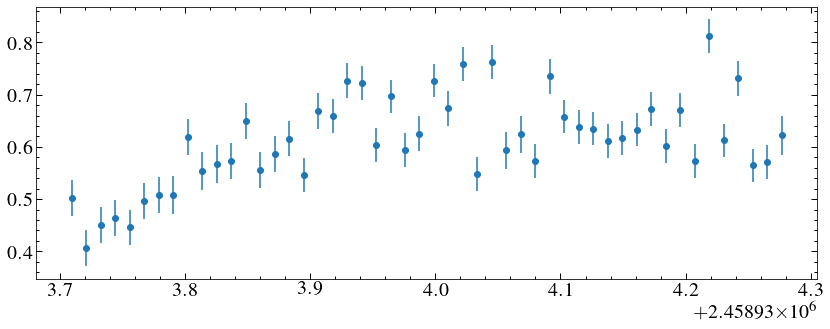

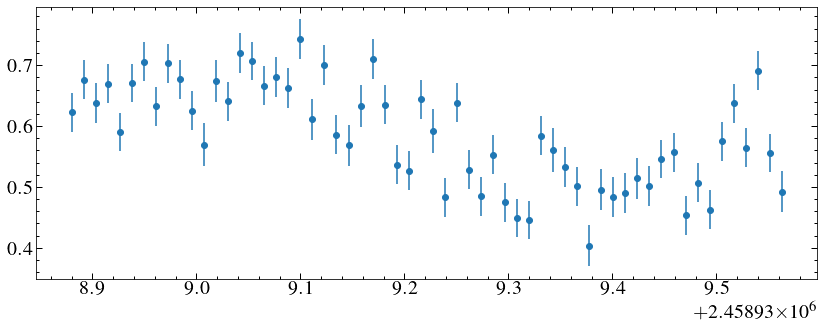

In [15]:
times = np.array([], dtype=float)
counts = np.array([], dtype=float)
error = np.array([], dtype=float)
for ob in obs:
    lc = fits.getdata('{}/lc'.format(ob), 1)   
    bg = fits.getdata('{}/lc_bg'.format(ob), 1)
    bgscale = fits.getheader('{}/lc_bg'.format(ob), 1)['BACKSCAL']
    mjdref = fits.getheader('{}/lc'.format(ob), 1)['MJDREF']
#     print(lc['AREA'])
#     print(bg['AREA'])
    t, c, ce, bgc, bgce = lc['TIME']*u.s, lc['COUNT_RATE'], lc['COUNT_RATE_ERR'], bg['COUNT_RATE']/bgscale, bg['COUNT_RATE_ERR']
    t = (t.to(u.d).value + mjdref+ 2400000.5)*u.cds.JD
    nc = c-bgc
    ne = (ce**2+bgce**2)
    plt.errorbar(t[1:-1].value, nc[1:-1], yerr=ne[1:-1], marker='o', ls='none')
    times = np.concatenate((times, t[1:-1]))
    counts = np.concatenate((counts, nc[1:-1]))
    error = np.concatenate((error, ne[1:-1]))
    plt.show()

In [16]:
# lc1[1].header

<ErrorbarContainer object of 3 artists>

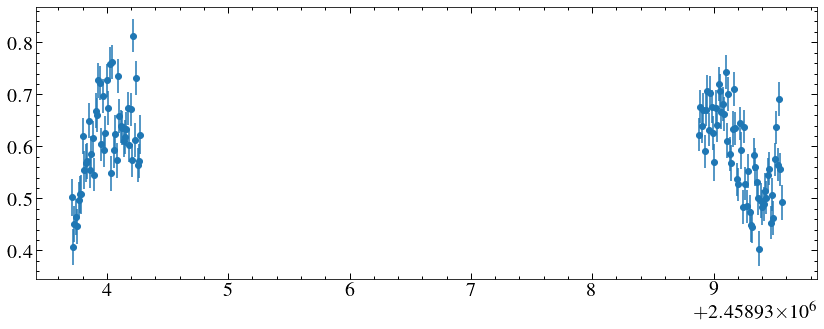

In [17]:
plt.errorbar(times.value, counts, yerr=error, marker='o', ls='none')

In [18]:
# tfold = time/(1.1468*u.d.to(u.s)) % 1

In [19]:
# plt.errorbar(tfold, counts, yerr=error, marker='o', ls='none')

In [20]:
lc = lk.LightCurve(time = times, flux=counts, flux_err=error)

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

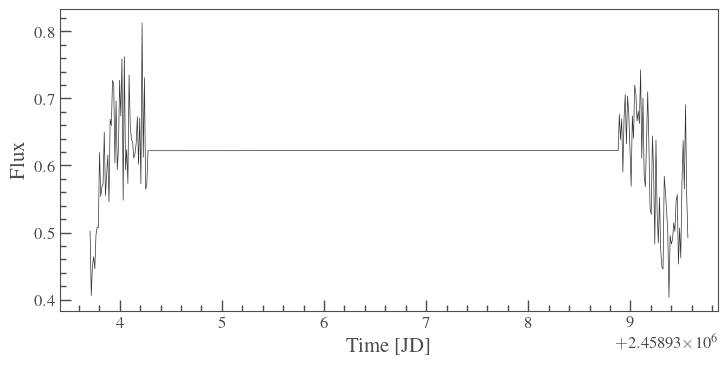

In [21]:
lc.plot()

<AxesSubplot:xlabel='Phase', ylabel='Flux'>

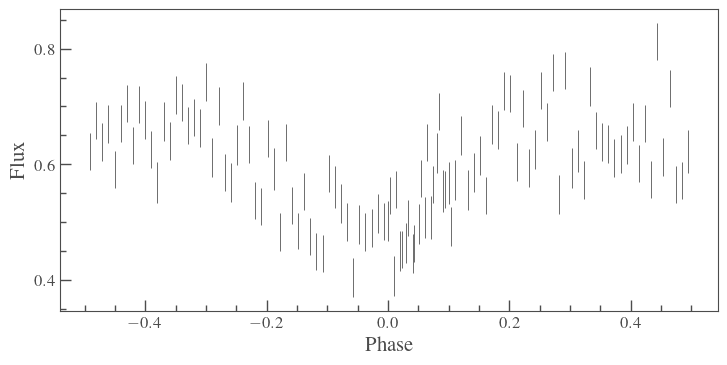

In [22]:
lcf = lc.fold(1.1468*u.d, normalize_phase=True)
lcf.errorbar()

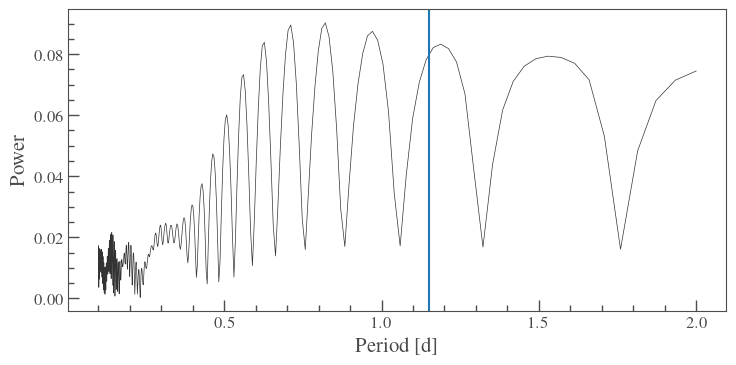

In [23]:
pg = lc.to_periodogram(oversample_factor=10, minimum_period=0.1*u.d, maximum_period=2*u.d)
pg.plot()
plt.axvline(1.15)

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

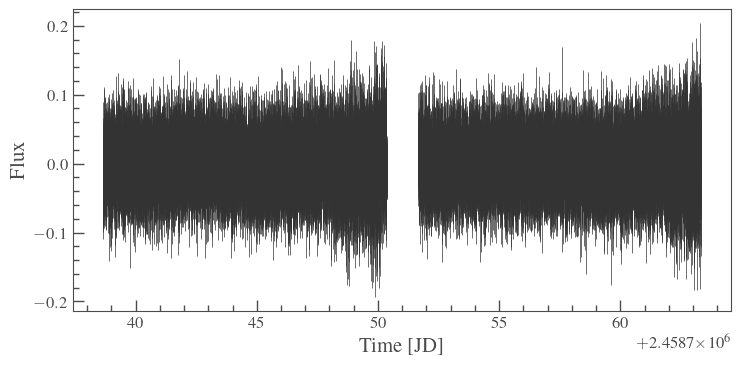

In [24]:
s15fits = '../../tess/tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits'
s16fits = '../../tess/tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits'

for i, ft in enumerate([s15fits, s16fits]):
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    lct = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    if i == 0:
        lc15 = lct
    else:
        lc16= lct
        lct +=lct
lct.time +=2457000
lct.errorbar()

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

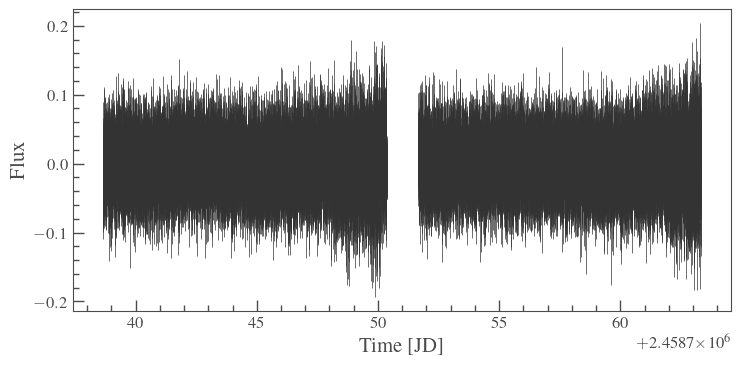

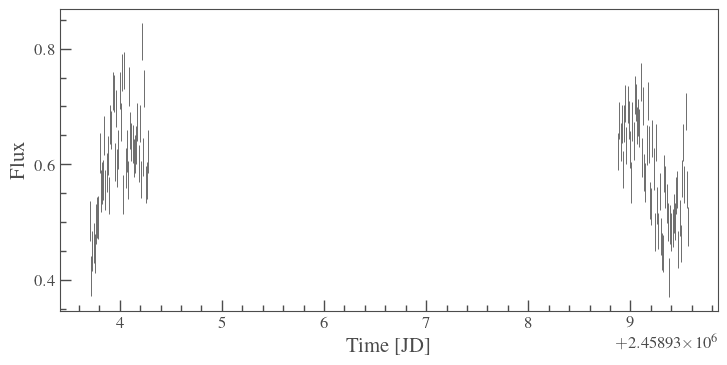

In [25]:
lct.errorbar()
lc.errorbar()

In [40]:
ip_peg = coord.SkyCoord("23:23:08.55", "+18:24:59.3",
                        unit=(u.hourangle, u.deg), frame='icrs')
gd394 = coord.SkyCoord("21:12:44.04", "+50:06:17.9",
                        unit=(u.hourangle, u.deg), frame='icrs')
pole = coord.EarthLocation(0, 0, 0*u.m) 
times2 = time.Time([56325.95833333, 56325.978254], format='mjd',
                  scale='utc', location = pole) 
# times2 = time.Time([, format='mjd', scale='utc', location = pole)
ltt_bary = times2.light_travel_time(ip_peg)   
# lc.time = (times.utc +ltt.bary)*u.cds.JD


AttributeError: Longitude instance has no attribute 'radian'

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

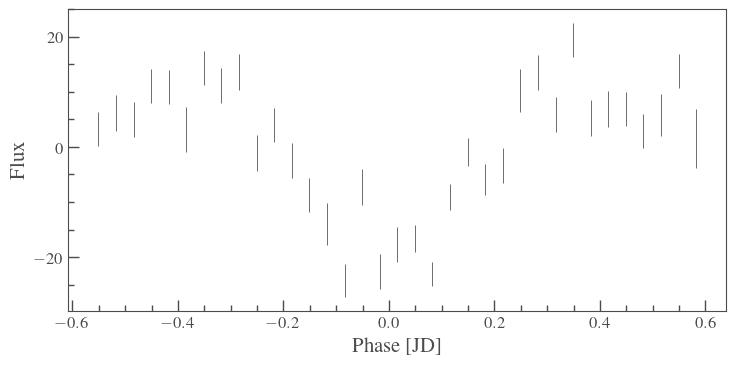

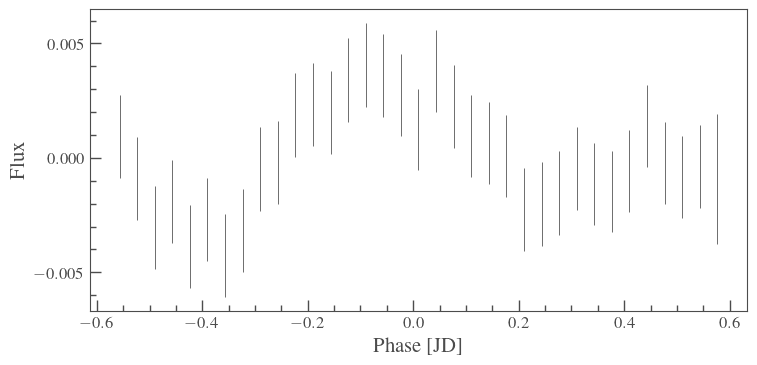

In [41]:
lcn = lc.normalize()
lcn.flux -= 1
lcn.flux *= 100
lcn.flux_err *= 100


eph = 2458737.560*u.d
period = 1.1468*u.d

clcf = lcn.fold(period, epoch_time=eph).bin(0.8*u.hr)
tlcf = lct.fold(period, epoch_time=eph).bin(0.8*u.hr)

clcf.errorbar()
tlcf.errorbar()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


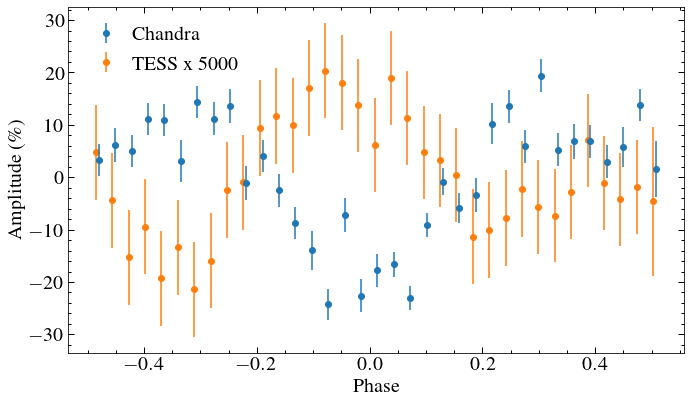

In [42]:
scale = 5000

plt.figure(figsize=(10, 6))
plt.errorbar(clcf.time.value/period.value, clcf.flux, yerr=clcf.flux_err, marker='o', ls='none', label = 'Chandra', zorder=10)
plt.errorbar(tlcf.time.value/period.value, tlcf.flux*scale, yerr=tlcf.flux_err*scale, marker='o', ls='none', label = 'TESS x {}'.format(scale))
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Amplitude (\%)')
plt.tight_layout()
plt.savefig('plots/chandra_v_tess.pdf', dpi = 150)
plt.savefig('plots/chandra_v_tess.png', dpi = 150)

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude         frequency            phase      
    ----------------- ------------------ -----------------
    13.14387255532822 0.8566079898035084 37827.57973310593
Period = 1.1673951351182041 0.009536263277472203


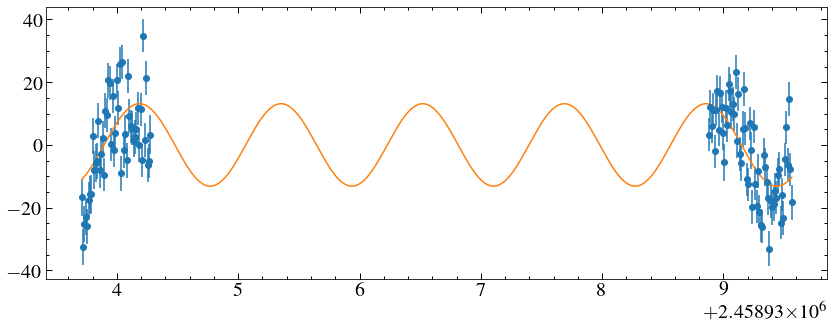

In [43]:
fitter = fitting.LevMarLSQFitter()
sin_mod =  models.Sine1D(amplitude=25, frequency=1/period.value, phase=0.1)
sin_fit = fitter(sin_mod, lcn.time.value, lcn.flux.value, weights = 1/lcn.flux_err.value, maxiter=10000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

timefit = np.linspace(lcn.time[0].value, lcn.time[-1].value, 1000)
plt.errorbar(lcn.time.value, lcn.flux, yerr=lcn.flux_err, marker='o', ls='none')
plt.plot(timefit, sin_fit(timefit))
print(sin_fit)
print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      frequency       phase       
    ------------------ --------- ------------------
    12.952543431082956       1.0 0.7917290264472903
Period = 1.0 0.018689461611190512


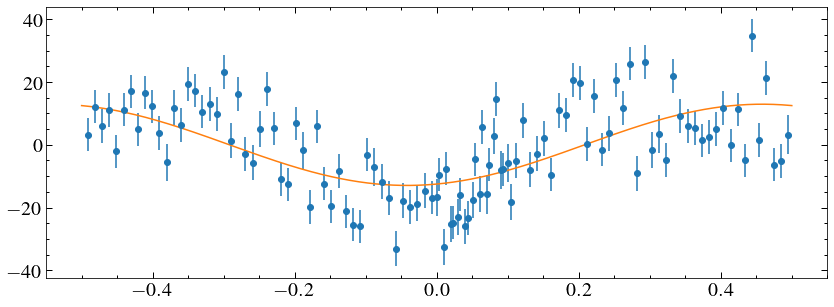

In [48]:
clcf2 = lcn.fold(period, normalize_phase=True)


sin_mod =  models.Sine1D(amplitude=25, frequency=1, phase=0.5, fixed=dict(frequency=True))
sin_fit = fitter(sin_mod, clcf2.time.value, clcf2.flux.value, weights = 1/clcf2.flux_err.value, maxiter=10000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

timefit = np.linspace(-0.5, 0.5, 1000)
plt.errorbar(clcf2.time.value, clcf2.flux, yerr=clcf2.flux_err, marker='o', ls='none')
plt.plot(timefit, sin_fit(timefit))
print(sin_fit)
print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))